# Winnipeg Service Request Project
### Author: Henrique Proba
In this project I'm using a dataset from the Winnipeg Open Data Portal which displays People's service requests. My goal here
is to analyze this data and display some interesting insights, plots and in the end show a map where each service request is located
on it.

ps: The Dataset can be found here: https://data.winnipeg.ca/Contact-Centre-311/311-Service-Request/4her-3th5


###  1 - Exploratory Data Analysis & Data Cleaning
####  1.1 - Importing the libraries that I'll be using.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gdp
from shapely.geometry import Point, Polygon

#### 1.2 - Reading the dataset and displaying the first 05 rows.

In [9]:
file_path = r'C:\Personal_Projects\311_Service_Request.csv'
#parse_dates argument transforms the Date Column Object into Datetime.
df = pd.read_csv(file_path, encoding='latin-1', parse_dates=["Date"], usecols=['Date', 'Service Area', 'Service Request', 'Ward', 'Neighbourhood', 'Location 1'])
df.head()

,Date,Service Area,Service Request,Ward,Neighbourhood,Location 1
0,2019-06-19 00:45:00,By Law Enforcement,Neighbourhood Liveability Complaint,River Heights - Fort Garry,Grant Park,"(49.8548442484409, -97.1570091977867)"
1,2019-06-19 00:12:00,Parks and Urban Foresty,Boulevard Mowing,St. Boniface,Southdale,"(49.8459755910878, -97.0778570280585)"
2,2019-06-18 23:54:00,Street Maintenance,Sidewalk Repairs,Mynarski,Jefferson,"(49.9379677899217, -97.1327417441262)"
3,2019-06-18 23:52:00,By Law Enforcement,Neighbourhood Liveability Complaint,St. Vital,Glenwood,"(49.8721502899163, -97.1092643614259)"
4,2019-06-18 23:29:00,Animal Services,Dog Complaint,Transcona,Kildare-Redonda,"(49.899399521068, -96.9818692405944)"


#### 1.3 - Having acloser look at the data.

In [4]:
# This can be considered a 'clean' dataset since there are only two columns (Ward and Neighbourhood) with one missing value each.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137613 entries, 0 to 137612
Data columns (total 6 columns):
Date               137613 non-null object
Service Area       137613 non-null object
Service Request    137613 non-null object
Ward               137612 non-null object
Neighbourhood      137612 non-null object
Location 1         137613 non-null object
dtypes: object(6)
memory usage: 3.1+ MB


#### 1.4 - Filling missing data

In [10]:
# Checking the null Values. I had a closer look in google maps and based on its coordinates the service request happened outside of the city of Winnipeg.
df[df.isnull().any(axis=1)]

,Date,Service Area,Service Request,Ward,Neighbourhood,Location 1
1607,2019-06-12 08:59:00,Street Maintenance,Graffiti,NaN,NaN,"(49.7194459598922, -97.1723204825164)"
2907,2019-06-06 08:47:00,Street Maintenance,Graffiti,NaN,NaN,"(49.7224429553946, -97.1716124031503)"
4090,2019-05-30 09:46:00,Garbage & Recycling,Missed Recycling Collection,NaN,NaN,"(49.872781685674, -97.3594778226616)"
111905,2017-06-27 11:32:00,Parks and Urban Foresty,Graffiti,NaN,NaN,"(49.7211644035618, -97.175328758492)"


In [11]:
# In this case I'll basically fill the NaN from the Ward and Neighbourhood columns with the string 'GWA' (Greater Winnipeg Area)
df.fillna('GWA', inplace=True)

###  2 - Engineering 

In [12]:
# The idea here is to generate a new column "Season" by creating this function that will further be applied using the Date Column.
def date_to_season(x):
    if x == 1:
        return 'Winter'
    if x == 2:
        return 'Spring'
    if x == 3:
        return 'Summer'
    if x == 4:
        return 'Autumn'
    
df['Season'] = df['Date'].dt.date.apply(lambda dt: (dt.month%12 + 3)//3)
df['Season'] = df['Season'].apply(date_to_season)

In [13]:
# Same Process here but this time I'll create a "Period of the Day" column.
def period_of_the_day(x):
    if x >= 6 and x <= 12:
        return 'Morning'
    if x > 12 and x <= 17:
        return 'Afternoon'
    if x > 17 and x <= 20:
        return 'Evening'
    if (x > 20) | (x < 6):
        return 'Night'
    
df['Period'] = df['Date'].dt.hour.apply(period_of_the_day)

In [14]:
#Checking the results of all the engineering that was applied so far
df.head()

,Date,Service Area,Service Request,Ward,Neighbourhood,Location 1,Season,Period
0,2019-06-19 00:45:00,By Law Enforcement,Neighbourhood Liveability Complaint,River Heights - Fort Garry,Grant Park,"(49.8548442484409, -97.1570091977867)",Summer,Night
1,2019-06-19 00:12:00,Parks and Urban Foresty,Boulevard Mowing,St. Boniface,Southdale,"(49.8459755910878, -97.0778570280585)",Summer,Night
2,2019-06-18 23:54:00,Street Maintenance,Sidewalk Repairs,Mynarski,Jefferson,"(49.9379677899217, -97.1327417441262)",Summer,Night
3,2019-06-18 23:52:00,By Law Enforcement,Neighbourhood Liveability Complaint,St. Vital,Glenwood,"(49.8721502899163, -97.1092643614259)",Summer,Night
4,2019-06-18 23:29:00,Animal Services,Dog Complaint,Transcona,Kildare-Redonda,"(49.899399521068, -96.9818692405944)",Summer,Night


### 3 - Visualization and Insights

#### 3.1 Which Year had the highest service requests number ?

In [15]:
df['Date'].groupby(df['Date'].dt.year).agg('count')

Date
2017    71145
2018    51169
2019    27891
Name: Date, dtype: int64

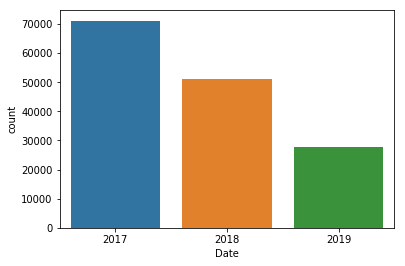

In [17]:
sns.countplot(df['Date'].dt.year)

-  Unfortunately, the dataset is only covering 03 years of data but it seems (if the trend continues) that 2019 will have more service requests than 2018.

#### 3.2 - Which Months usually have the highest service requests number ? 

In [18]:
# Let's first check in Detail each month of every year
df['Date'].groupby([df['Date'].dt.year,df['Date'].dt.month]).count()

Date  Date
2017  1       10699
      2        4642
      3        6039
      4        4599
      5        5733
      6        7451
      7        5902
      8        5872
      9        4527
      10       9063
      11       3701
      12       2917
2018  1        3290
      2        2550
      3        7673
      4        4292
      5        5011
      6        5440
      7        5331
      8        4743
      9        3575
      10       3466
      11       3116
      12       2682
2019  1        4155
      2        5039
      3        5159
      4        4958
      5        4836
      6        3744
Name: Date, dtype: int64

In [19]:
# Now let's create a dataframe that won't count the year of 2019 and then group the months.
df_no_19 = df[(df['Date'].dt.year == 2018) | (df['Date'].dt.year == 2017)]
df_no_19.groupby(df_no_19['Date'].dt.month)['Service Request'].size()

Date
1     13989
2      7192
3     13712
4      8891
5     10744
6     12891
7     11233
8     10615
9      8102
10    12529
11     6817
12     5599
Name: Service Request, dtype: int64

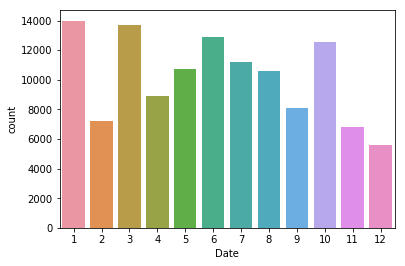

In [20]:
sns.countplot(df_no_19['Date'].dt.month)

-  Months from years 2018 and 2019 -> Months of January, March, June and October have a peak of service requests.

#### 3.3 - Which Time of the day has more service requests.

In [21]:
df_no_19.groupby(df['Period'])['Service Request'].size()

Period
Afternoon    38688
Evening      21935
Morning      50343
Night        11348
Name: Service Request, dtype: int64

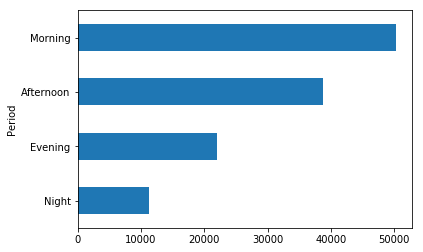

In [22]:
df_no_19.groupby('Period')['Service Request'].size().sort_values(ascending=True).plot(kind='barh')

-  Mornings are when service request are higher

#### 3.4 - Which Season has more service requests.

In [23]:
df_no_19.groupby('Season')['Service Request'].size()

Season
Autumn    27448
Spring    33347
Summer    34739
Winter    26780
Name: Service Request, dtype: int64

- Looks like Summer is the service request champion.

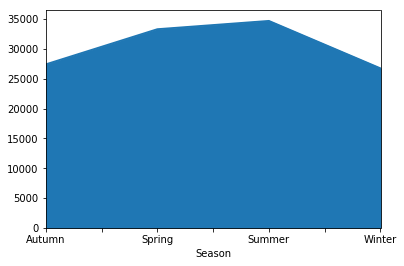

In [24]:
#Let's see the results as a area plot to have a better visual of the difference.
df_no_19.groupby('Season')['Service Request'].size().plot(kind='area')

#### 3.4 - Types of Service Areas, Services Requests and Neighbourhoods.

In [25]:
# Grouping By Service Request with the Service Area
df_no_19.groupby(['Service Area', 'Service Request']).size().sort_values(ascending=False)

Service Area             Service Request                    
Garbage & Recycling      Missed Garbage Collection              28484
By Law Enforcement       Neighbourhood Liveability Complaint    23093
Garbage & Recycling      Missed Recycling Collection            22935
Street Maintenance       Potholes                               13266
                         Snow Removal - Roads                    7056
                         Graffiti                                5180
Water                    Water Main Leak                         5125
Street Maintenance       Frozen Catch Basin                      3143
                         Sidewalk Repairs                        2841
Animal Services          Dog Complaint                           2614
Sewer & Drainage         Sewer Backup                            2356
Street Maintenance       Sanding                                 2279
                         Snow Removal - Sidewalks                1805
                         Litt

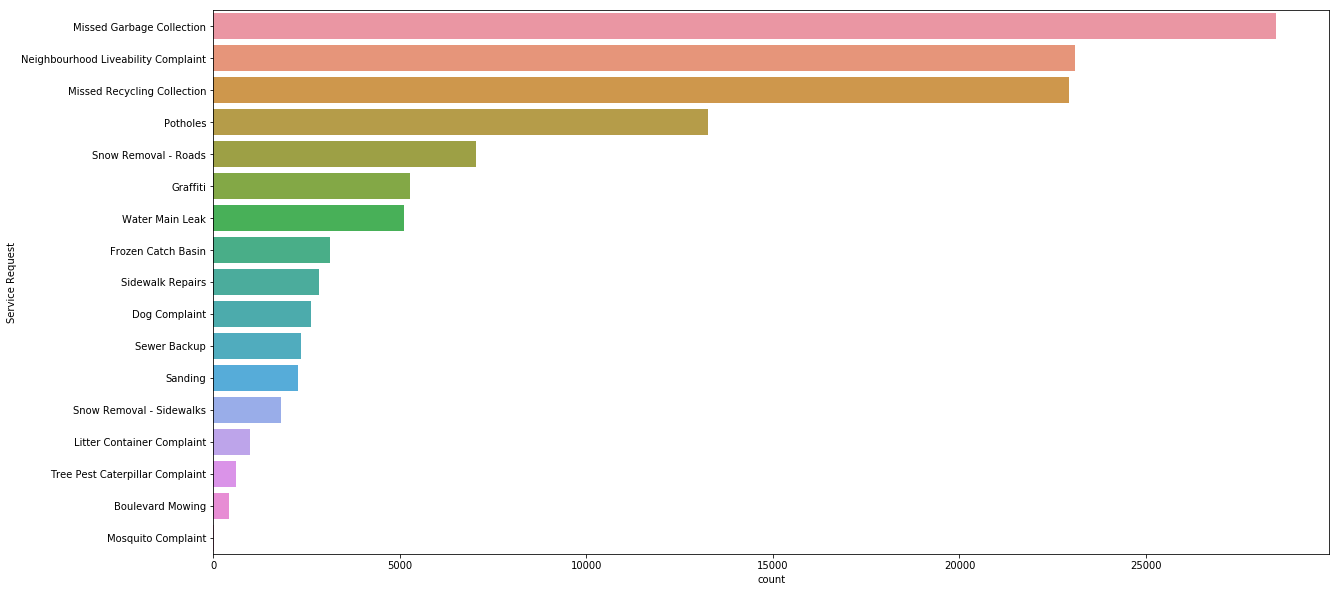

In [38]:
plt.subplots(figsize=(20,10))
sns.countplot(y=df_no_19['Service Request'], order=df_no_19['Service Request'].value_counts().index[0:17])
plt.show()

-  Each Service Area has one or many service requests. Looks like Missed Garbage Collection has the top position and Mosquito complaints (surprisingly!) has the least amount of service requests.

In [26]:
# Grouping By Service Request with the Neighbourhood
df_no_19.groupby('Neighbourhood')['Service Request'].size().sort_values(ascending = False).head(10)

Neighbourhood
William Whyte       4165
St. John's          3250
Rossmere-A          2401
Fort Richmond       2243
Daniel Mcintyre     2209
Chalmers            2084
River Park South    1944
Windsor Park        1844
Wolseley            1727
Minto               1672
Name: Service Request, dtype: int64

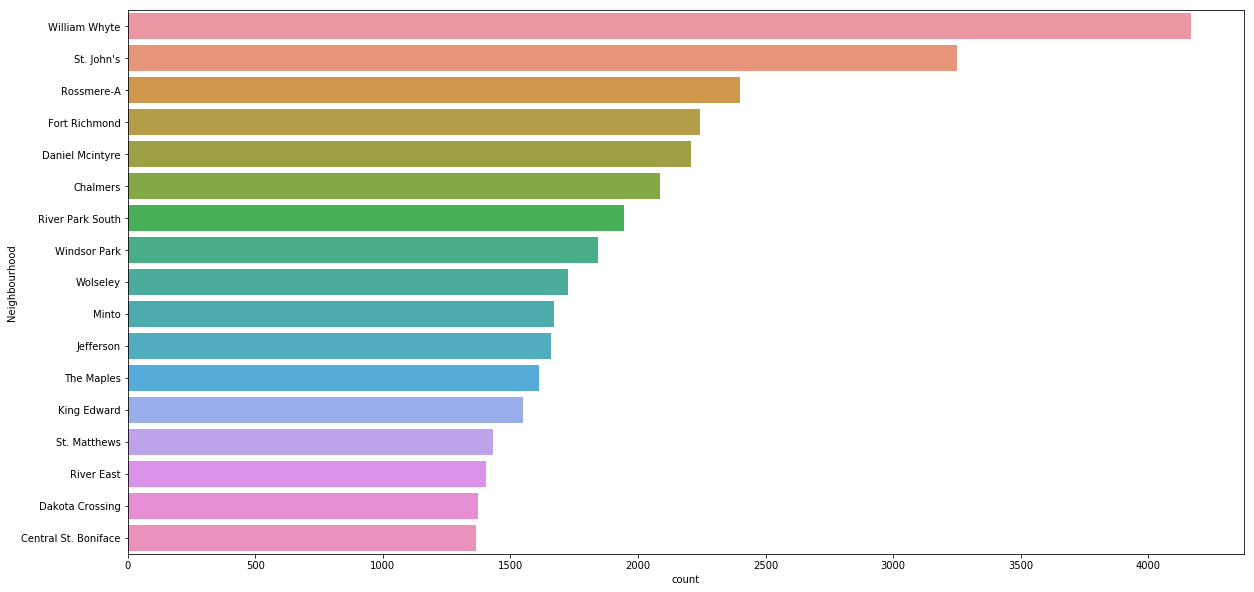

In [39]:
plt.subplots(figsize=(20,10))
sns.countplot(y=df_no_19['Neighbourhood'], order=df_no_19['Neighbourhood'].value_counts().index[0:17])
plt.show()

-  From the Neighbourhoods on the top 5 places, 04 are located north of downtown and 01 south of the city.

### 4- Display the Service Requests' location on a Winnipeg City Map.

#### 4.1 - Split the 'Location 1' column into Latitude and Longitude

In [29]:
street_map = gdp.read_file(r'C:\Personal_Projects\geo_export_75ee7088-a365-4b6c-bb1a-1c21fc52a19a.shp')

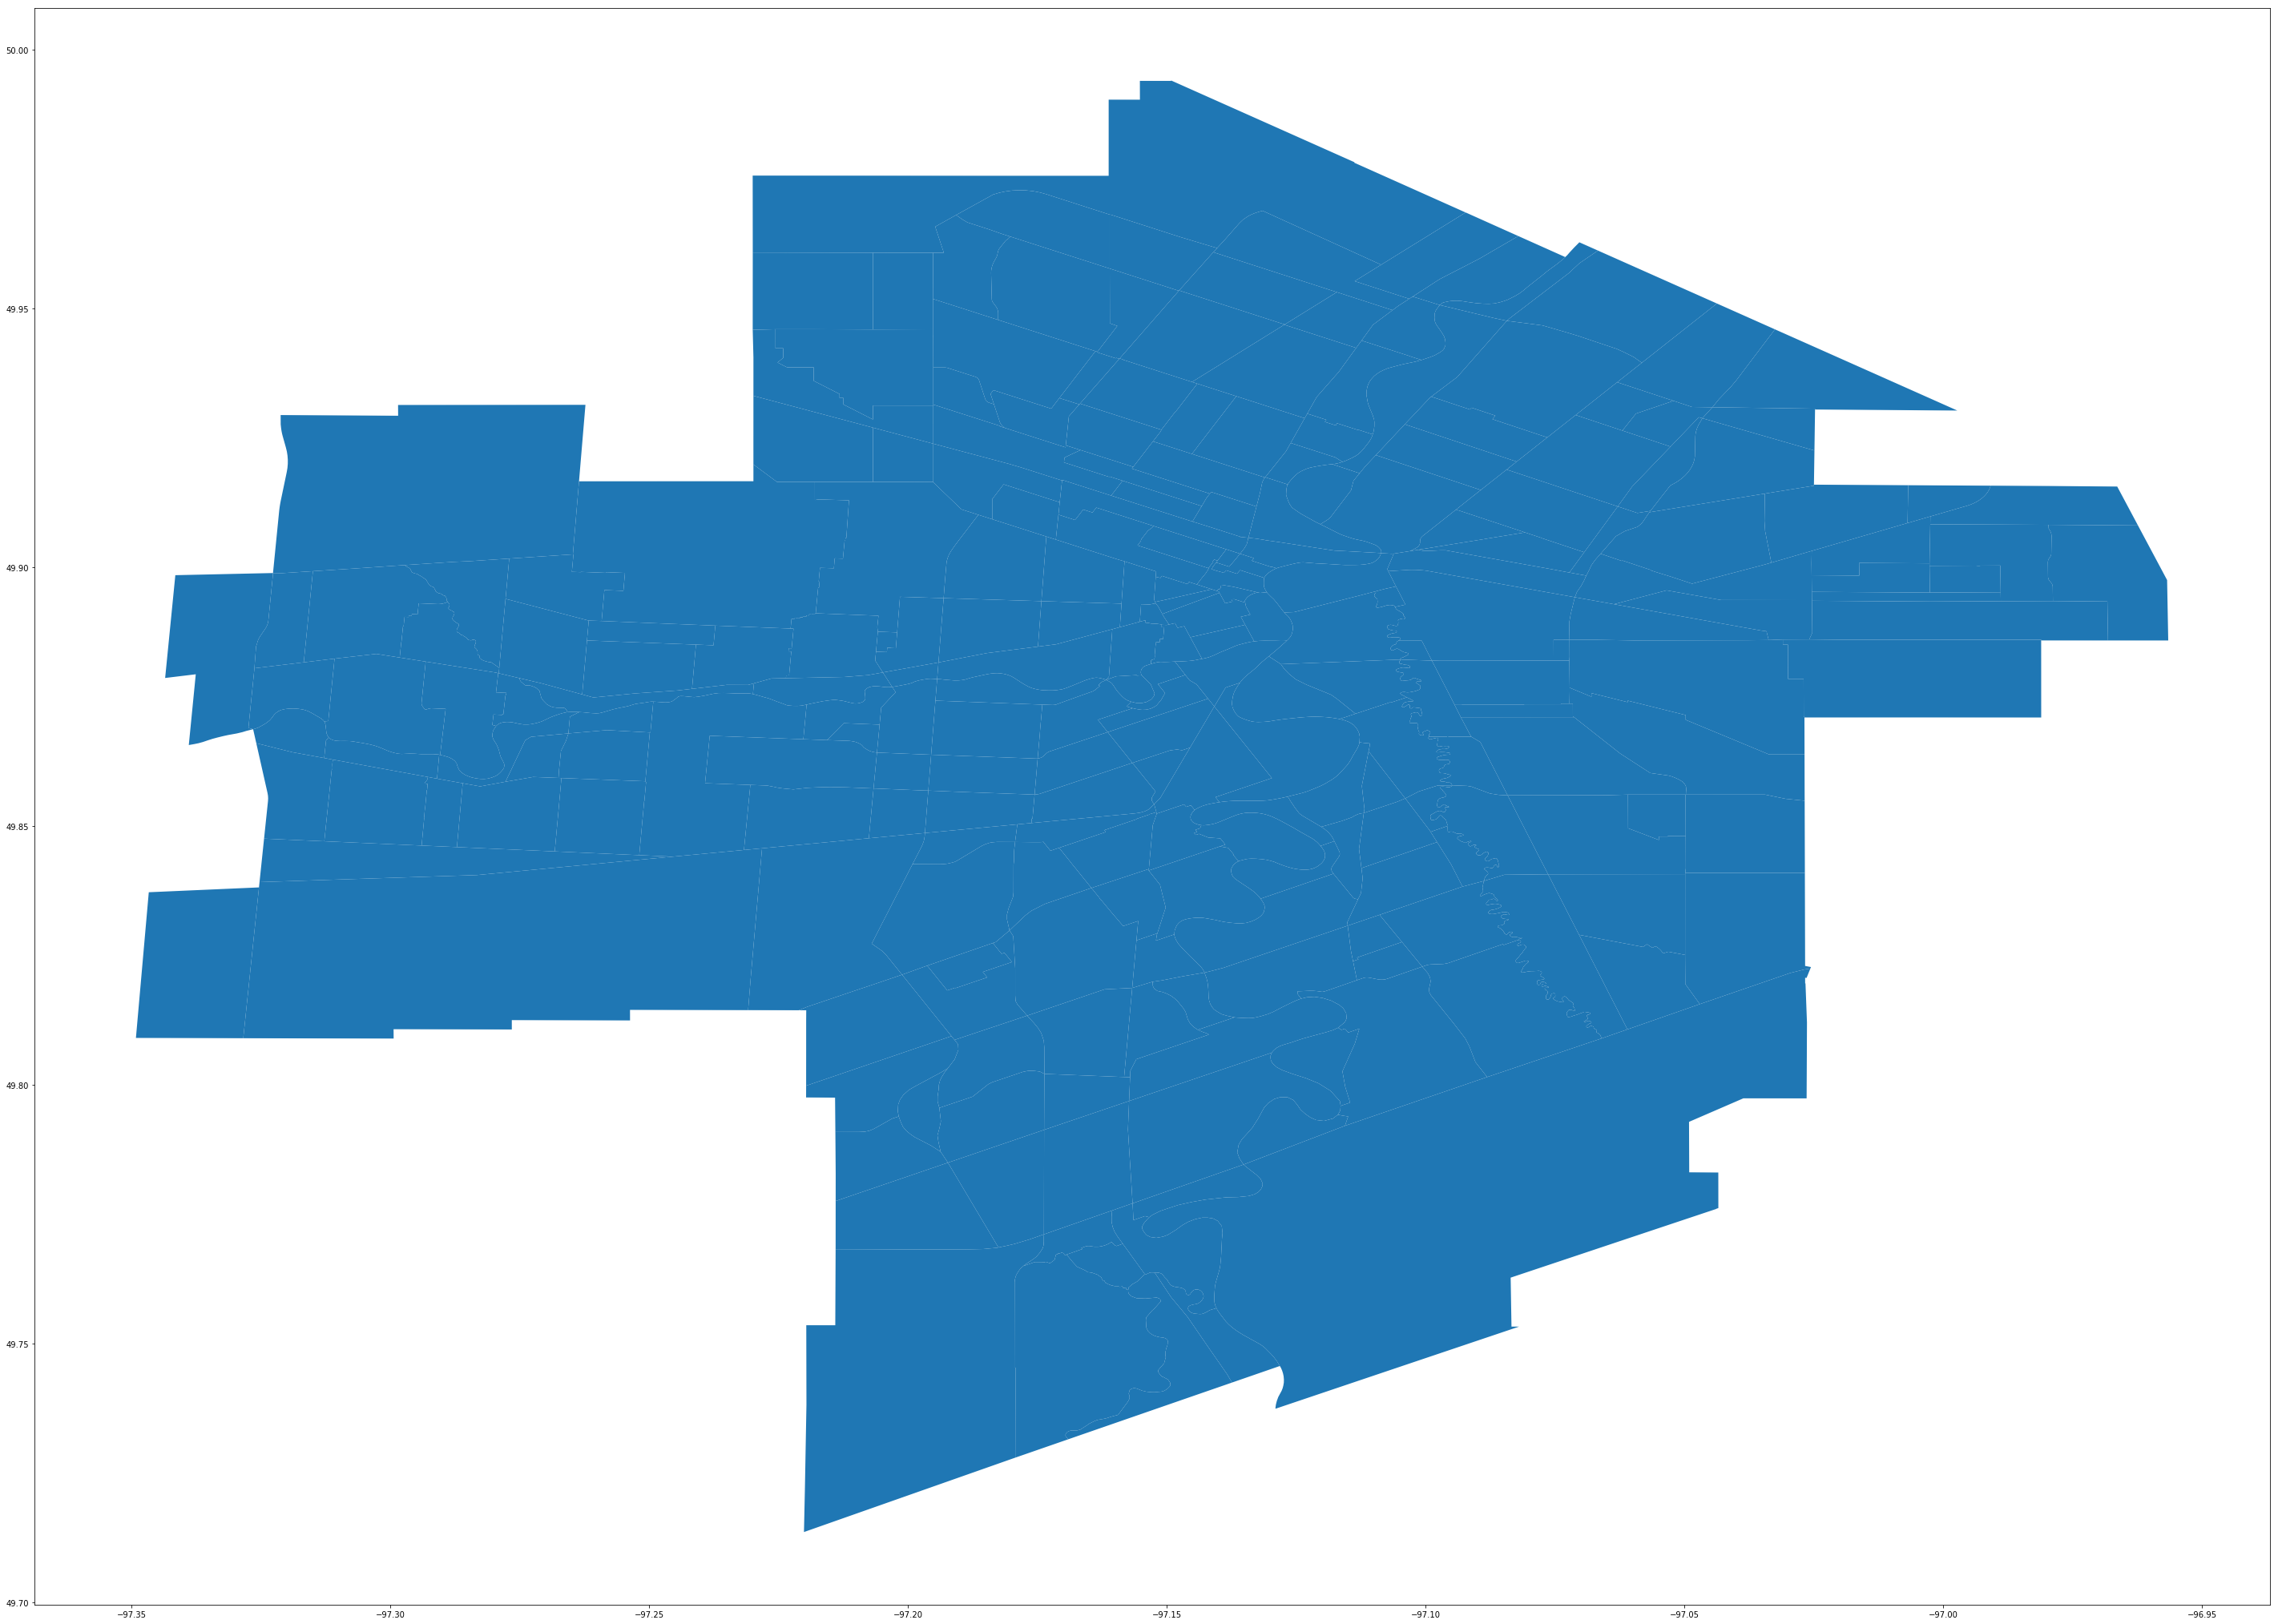

In [30]:
# checking if the map is being displayed correctly
fig,ax = plt.subplots(figsize = (50,50))
street_map.plot(ax = ax)

In [31]:
df_coord = df_no_19['Location 1'].str.strip('()').str.split(', ', expand=True).rename(columns={0:'Latitude', 1:'Longitude'}) 
df_coord.head()

,Latitude,Longitude
27891,49.9056759307873,-97.1498813062248
27892,49.8535272892101,-97.1751662361967
27893,49.9175587754188,-97.1016921869581
27894,49.8020539343855,-97.1800688757496
27895,49.8665314360815,-97.1578314453281


In [32]:
# Merging Lat and Long to the dataframe 
df2 = pd.concat([df_no_19, df_coord], axis=1)
df2.head()

,Date,Service Area,Service Request,Ward,Neighbourhood,Location 1,Season,Period,Latitude,Longitude
27891,2018-12-31 23:27:00,Street Maintenance,Snow Removal - Roads,Point Douglas,Centennial,"(49.9056759307873, -97.1498813062248)",Winter,Night,49.9056759307873,-97.1498813062248
27892,2018-12-31 21:39:00,Garbage & Recycling,Missed Garbage Collection,River Heights - Fort Garry,Grant Park,"(49.8535272892101, -97.1751662361967)",Winter,Night,49.8535272892101,-97.1751662361967
27893,2018-12-31 21:26:00,Garbage & Recycling,Missed Recycling Collection,Elmwood - East Kildonan,Chalmers,"(49.9175587754188, -97.1016921869581)",Winter,Night,49.9175587754188,-97.1016921869581
27894,2018-12-31 20:48:00,Garbage & Recycling,Missed Recycling Collection,Waverley West,Bridgwater Forest,"(49.8020539343855, -97.1800688757496)",Winter,Evening,49.8020539343855,-97.1800688757496
27895,2018-12-31 20:34:00,Garbage & Recycling,Missed Garbage Collection,Fort Rouge - East Fort Garry,Earl Grey,"(49.8665314360815, -97.1578314453281)",Winter,Evening,49.8665314360815,-97.1578314453281


In [33]:
df2[['Latitude', 'Longitude']] = df2[['Latitude', 'Longitude']].astype(float)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122314 entries, 27891 to 150204
Data columns (total 10 columns):
Date               122314 non-null datetime64[ns]
Service Area       122314 non-null object
Service Request    122314 non-null object
Ward               122314 non-null object
Neighbourhood      122314 non-null object
Location 1         122314 non-null object
Season             122314 non-null object
Period             122314 non-null object
Latitude           122314 non-null float64
Longitude          122314 non-null float64
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 11.0+ MB


#### 4.2 - Creating Points for Lat and Long.

In [34]:
# A Point is essentially a single object that describes the longitude and latitude of a data-point. 
geometry = [Point(xy) for xy in zip( df2['Longitude'], df2['Latitude'])]
geometry[:3]

In [35]:
crs = {'init': 'epsg:4326'}

In [36]:
df2 = gdp.GeoDataFrame(df2, crs=crs, geometry=geometry)
df2.head()

,Date,Service Area,Service Request,Ward,Neighbourhood,Location 1,Season,Period,Latitude,Longitude,geometry
27891,2018-12-31 23:27:00,Street Maintenance,Snow Removal - Roads,Point Douglas,Centennial,"(49.9056759307873, -97.1498813062248)",Winter,Night,49.905676,-97.149881,POINT (-97.1498813062248 49.9056759307873)
27892,2018-12-31 21:39:00,Garbage & Recycling,Missed Garbage Collection,River Heights - Fort Garry,Grant Park,"(49.8535272892101, -97.1751662361967)",Winter,Night,49.853527,-97.175166,POINT (-97.1751662361967 49.8535272892101)
27893,2018-12-31 21:26:00,Garbage & Recycling,Missed Recycling Collection,Elmwood - East Kildonan,Chalmers,"(49.9175587754188, -97.1016921869581)",Winter,Night,49.917559,-97.101692,POINT (-97.1016921869581 49.9175587754188)
27894,2018-12-31 20:48:00,Garbage & Recycling,Missed Recycling Collection,Waverley West,Bridgwater Forest,"(49.8020539343855, -97.1800688757496)",Winter,Evening,49.802054,-97.180069,POINT (-97.1800688757496 49.8020539343855)
27895,2018-12-31 20:34:00,Garbage & Recycling,Missed Garbage Collection,Fort Rouge - East Fort Garry,Earl Grey,"(49.8665314360815, -97.1578314453281)",Winter,Evening,49.866531,-97.157831,POINT (-97.1578314453281 49.8665314360815)


#### 4.3 - Display the top 5 Service Requests in a Winnipeg city map

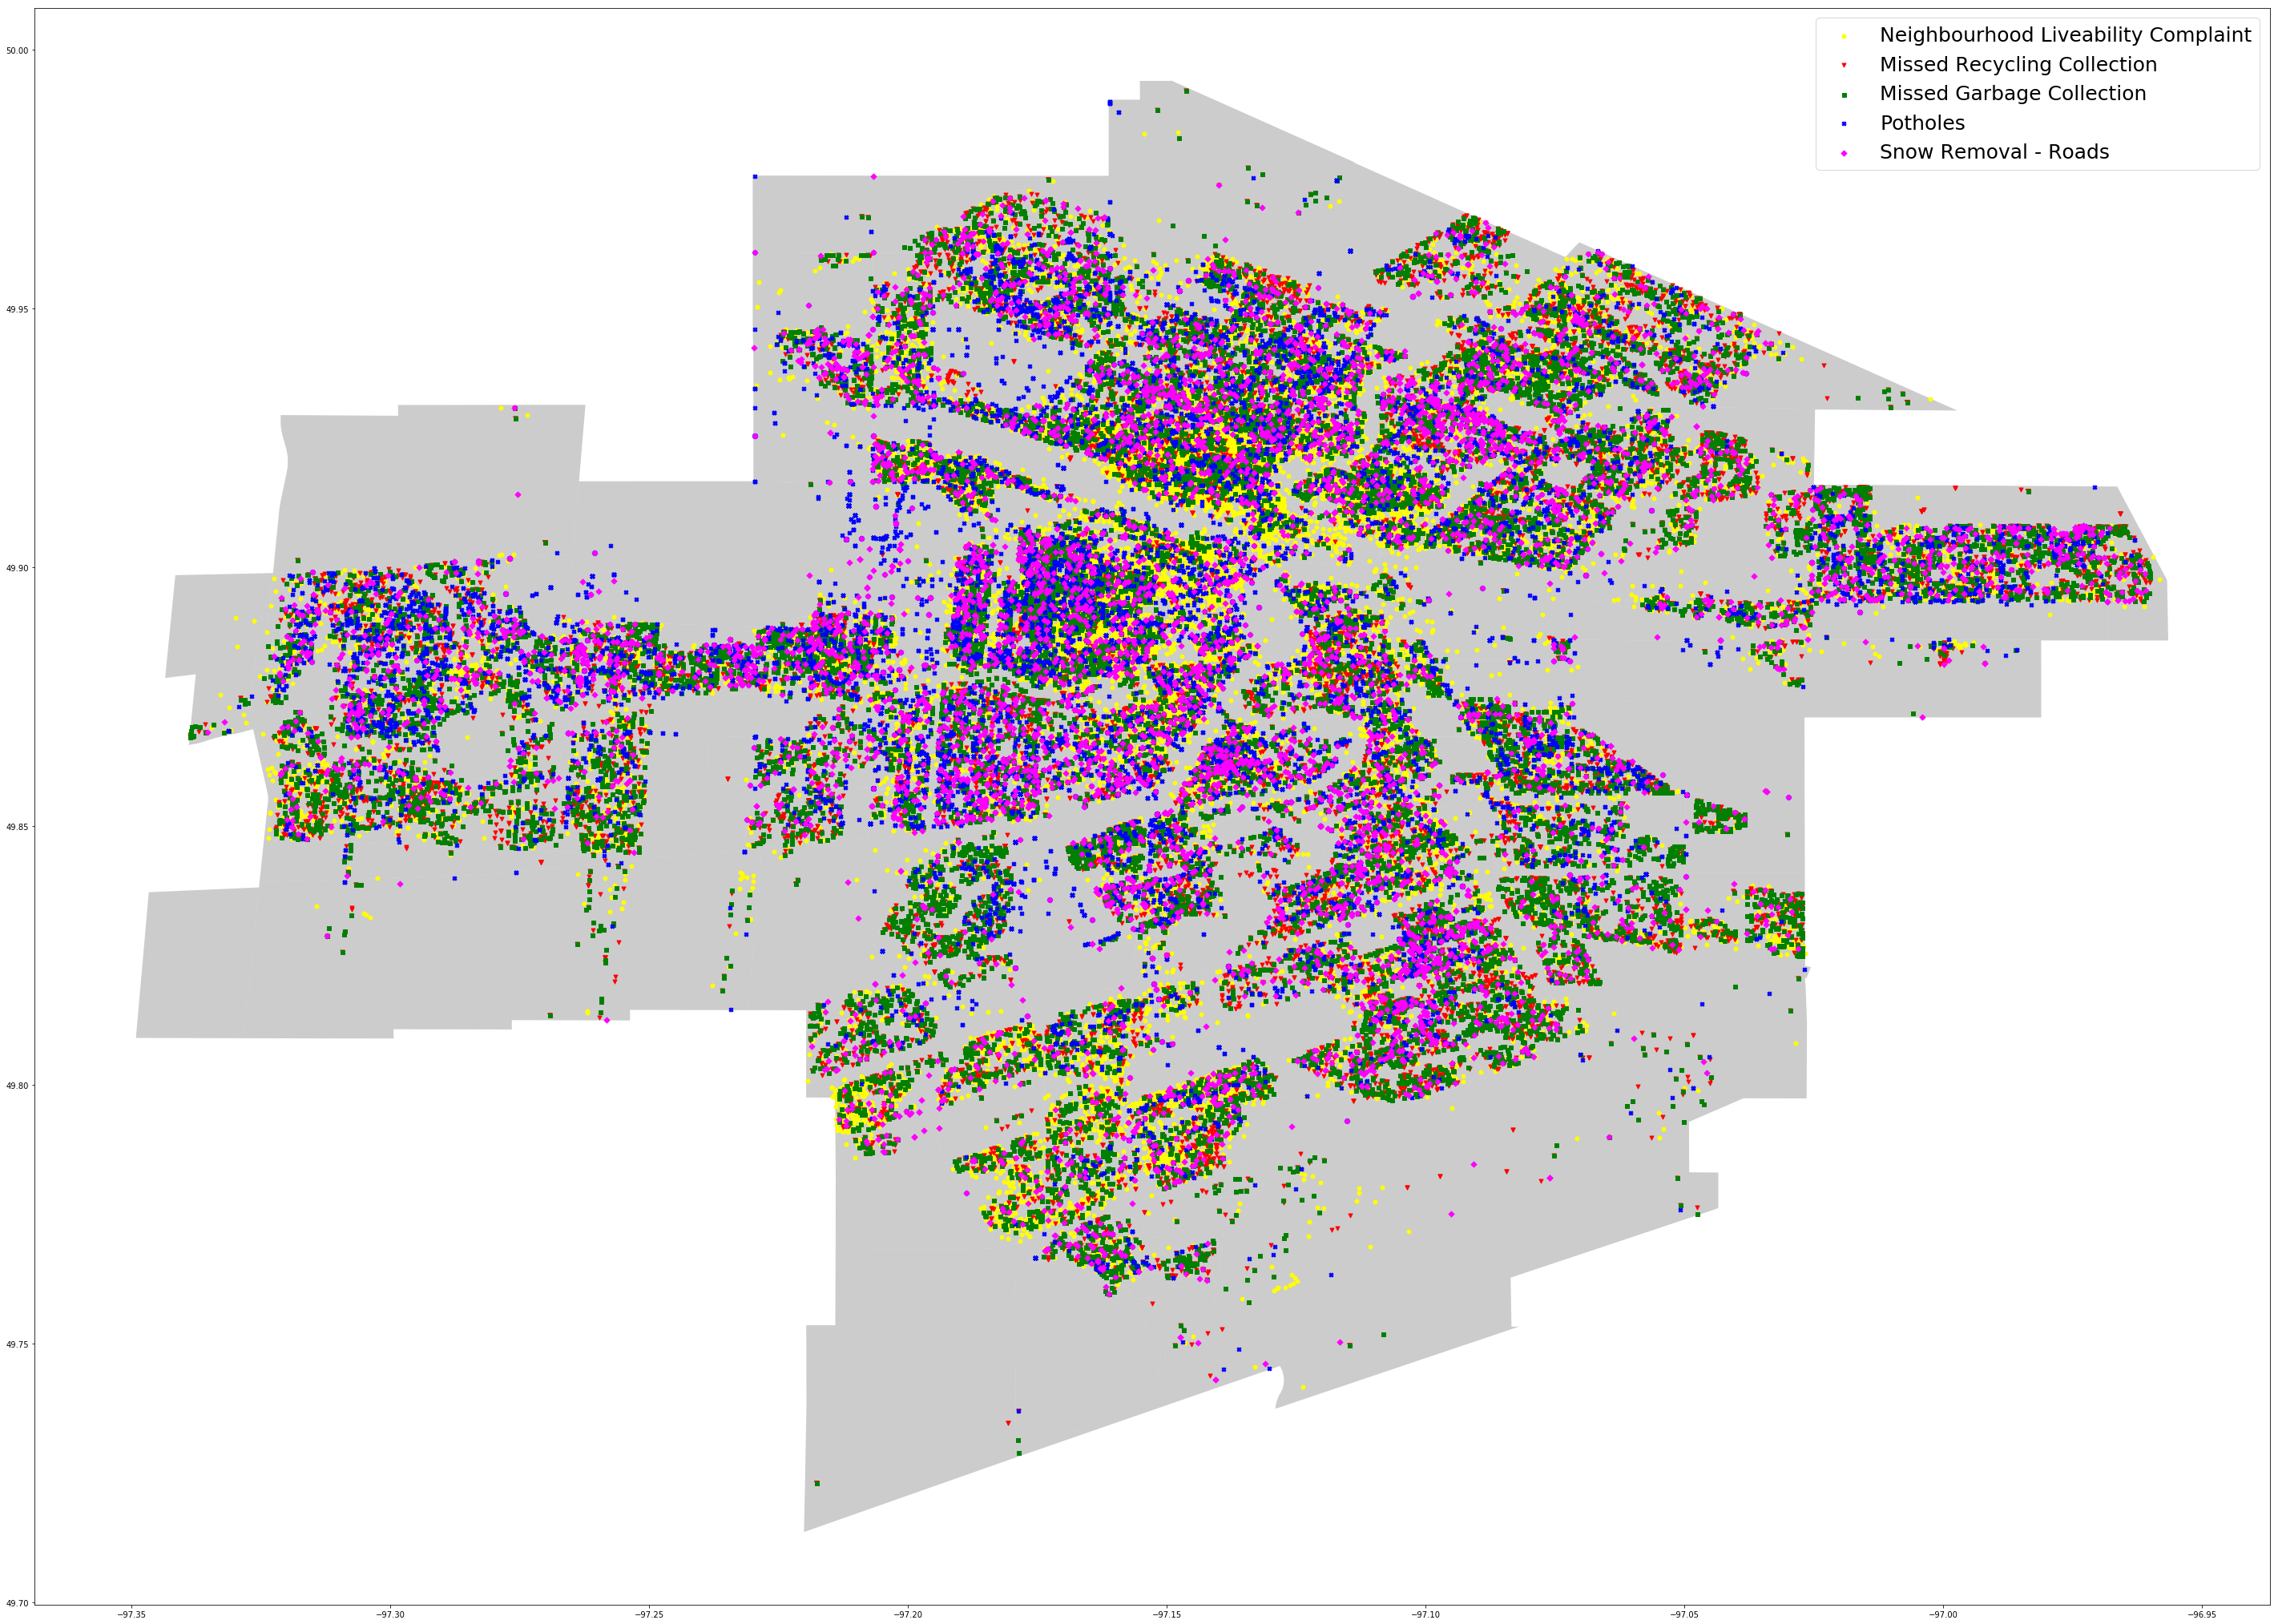

In [37]:
fig,ax = plt.subplots(figsize=(50,50))
street_map.plot(ax=ax, alpha=0.4, color="grey")
df2[df2['Service Request'] == 'Neighbourhood Liveability Complaint'].plot(ax = ax, markersize =25, color='yellow', marker='o', label='Neighbourhood Liveability Complaint')
df2[df2['Service Request'] == 'Missed Recycling Collection'].plot(ax = ax, markersize =25, color='red', marker='v', label='Missed Recycling Collection')
df2[df2['Service Request'] == 'Missed Garbage Collection'].plot(ax = ax, markersize =25, color='green', marker='s', label='Missed Garbage Collection')
df2[df2['Service Request'] == 'Potholes'].plot(ax = ax, markersize =25, color='blue',marker='X', label='Potholes')
df2[df2['Service Request'] == 'Snow Removal - Roads'].plot(ax = ax, markersize =25, color='fuchsia', marker='D', label='Snow Removal - Roads')
plt.legend(prop={'size':25})

- I can see a higher concentration of service requests in the center north region of the map.